In [123]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models

In [124]:
CSV_PATH = "/Users/singam/Downloads/wmms_labels.csv"
AUDIO_DIR = "/Users/singam/Downloads/wmms_audio"  
labels_df = pd.read_csv(CSV_PATH)
print("First few rows of the labels file:")
display(labels_df.head())
print("\nColumn names in the CSV:")
print(labels_df.columns.tolist())

First few rows of the labels file:


,file,species,label_id,duration_sec
0,clip_00000.wav,Spinner_Dolphin,26,NaN
1,clip_00001.wav,Bearded_Seal,1,NaN
2,clip_00002.wav,Weddell_Seal,29,NaN
3,clip_00003.wav,Harp_Seal,11,NaN
4,clip_00004.wav,False_Killer_Whale,7,NaN



Column names in the CSV:
['file', 'species', 'label_id', 'duration_sec']


In [125]:
CSV_PATH = "/Users/singam/Downloads/wmms_labels.csv"
labels_df = pd.read_csv(CSV_PATH)
FILENAME_COL = "file"      
LABEL_COL    = "species"   
data = labels_df[[FILENAME_COL, LABEL_COL]].dropna().copy()
print("Column names in wmms_labels.csv:")
print(labels_df.columns.tolist())
print("\nNumber of labelled audio clips:", len(data))
display(data.head())

Column names in wmms_labels.csv:
['file', 'species', 'label_id', 'duration_sec']

Number of labelled audio clips: 1357


,file,species
0,clip_00000.wav,Spinner_Dolphin
1,clip_00001.wav,Bearded_Seal
2,clip_00002.wav,Weddell_Seal
3,clip_00003.wav,Harp_Seal
4,clip_00004.wav,False_Killer_Whale


In [126]:
AUDIO_DIR = "/Users/singam/Downloads/wmms_audio" 
SR = 22050        
N_MELS = 128      
MAX_FRAMES = 128 
def load_mel_spectrogram(audio_path, sr=SR, n_mels=N_MELS, max_frames=MAX_FRAMES):
    y, sr = librosa.load(audio_path, sr=sr)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)
    if S_db.shape[1] < max_frames:
        pad_width = max_frames - S_db.shape[1]
        S_db = np.pad(S_db, ((0, 0), (0, pad_width)), mode="constant")
    else:
        S_db = S_db[:, :max_frames]
    return S_db

In [127]:
X_list = []
y_list = []
missing_files = 0
for _, row in data.iterrows():
    filename = row[FILENAME_COL]  
    label = row[LABEL_COL]         
    audio_path = os.path.join(AUDIO_DIR, filename)
    if not os.path.exists(audio_path):
        missing_files += 1
        continue
    try:
        spec = load_mel_spectrogram(audio_path)
        X_list.append(spec)
        y_list.append(label)
    except Exception as e:
        print(f"Error loading {audio_path}: {e}")
        continue
print(f"Loaded spectrograms for {len(X_list)} files.")
print(f"Missing or problematic files: {missing_files}")

/Users/singam/pyspark_env/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1184
  warnings.warn(
/Users/singam/pyspark_env/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1448
  warnings.warn(
/Users/singam/pyspark_env/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1460
  warnings.warn(


Loaded spectrograms for 1357 files.
Missing or problematic files: 0


In [128]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
X = np.array(X_list)  
num_samples = X.shape[0]
input_dim = N_MELS * MAX_FRAMES
X_flat = X.reshape(num_samples, input_dim)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(np.array(y_list))
num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)
print("Number of classes:", num_classes)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_flat, y_encoded,
    test_size=0.15,
    random_state=42,
    stratify=y_encoded
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1765,  
    random_state=42,
    stratify=y_temp
)
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)
X_min = X_train.min()
X_max = X_train.max()
X_train_norm = (X_train - X_min) / (X_max - X_min + 1e-8)
X_val_norm   = (X_val   - X_min) / (X_max - X_min + 1e-8)
X_test_norm  = (X_test  - X_min) / (X_max - X_min + 1e-8)

Classes: ['Atlantic_Spotted_Dolphin' 'Bearded_Seal' 'Beluga,_White_Whale'
 'Bottlenose_Dolphin' 'Bowhead_Whale' 'Clymene_Dolphin' 'Common_Dolphin'
 'False_Killer_Whale' 'Fin,_Finback_Whale' 'Frasers_Dolphin'
 'Grampus,_Rissos_Dolphin' 'Harp_Seal' 'Humpback_Whale' 'Killer_Whale'
 'Leopard_Seal' 'Long-Finned_Pilot_Whale' 'Melon_Headed_Whale'
 'Minke_Whale' 'Narwhal' 'Northern_Right_Whale'
 'Pantropical_Spotted_Dolphin' 'Ross_Seal' 'Rough-Toothed_Dolphin'
 'Short-Finned_Pacific_Pilot_Whale' 'Southern_Right_Whale' 'Sperm_Whale'
 'Spinner_Dolphin' 'Striped_Dolphin' 'Walrus' 'Weddell_Seal'
 'White-beaked_Dolphin' 'White-sided_Dolphin']
Number of classes: 32
Train shape: (949, 16384)
Validation shape: (204, 16384)
Test shape: (204, 16384)


In [129]:
import tensorflow as tf
from tensorflow.keras import layers, models
tf.random.set_seed(42)
model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 32)             │         4,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,557,472 (32.64 MB)

 Trainable params: 8,557,472 (32.64 MB)

 Non-trainable params: 0 (0.00 B)

In [130]:
BATCH_SIZE = 32
EPOCHS = 30
history = model.fit(
    X_train_norm, y_train,
    validation_data=(X_val_norm, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0485 - loss: 6.4249 - val_accuracy: 0.0931 - val_loss: 3.2960
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0695 - loss: 3.3396 - val_accuracy: 0.1127 - val_loss: 3.2185
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0717 - loss: 3.2527 - val_accuracy: 0.0882 - val_loss: 3.2120
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1043 - loss: 3.1648 - val_accuracy: 0.1176 - val_loss: 3.0244
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1328 - loss: 3.0911 - val_accuracy: 0.1373 - val_loss: 2.9533
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1128 - loss: 3.0515 - val_accuracy: 0.1422 - val_loss: 2.8747
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1475 - loss: 3.0036 - val_accuracy: 0.2108 - val_loss: 2.8819
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1296 - loss: 2.9867 - val_accuracy: 0.1716 - v

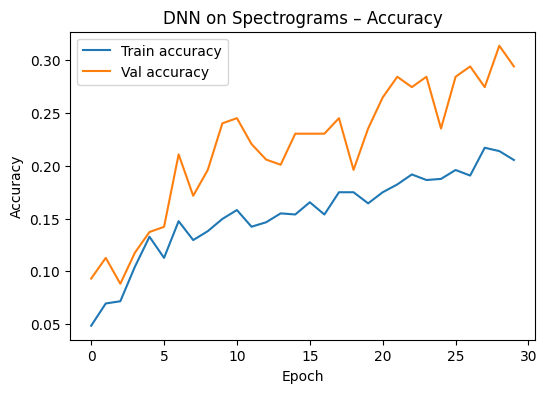

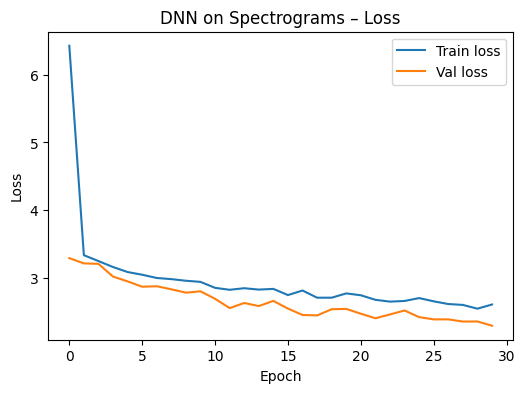

In [131]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("DNN on Spectrograms – Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DNN on Spectrograms – Loss")
plt.legend()
plt.show()

In [132]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
test_loss, test_acc = model.evaluate(X_test_norm, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
y_pred_probs = model.predict(X_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)
labels_used = np.unique(np.concatenate([y_test, y_pred]))
target_names_used = label_encoder.inverse_transform(labels_used)
print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred,
    labels=labels_used,
    target_names=target_names_used
))
cm = confusion_matrix(y_test, y_pred, labels=labels_used)
print("Confusion matrix:\n", cm)

Test accuracy: 0.2794
Test loss: 2.3502
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Classification Report:
                                  precision    recall  f1-score   support

        Atlantic_Spotted_Dolphin       0.00      0.00      0.00         7
                    Bearded_Seal       0.00      0.00      0.00         4
             Beluga,_White_Whale       0.00      0.00      0.00         6
              Bottlenose_Dolphin       0.00      0.00      0.00         3
                   Bowhead_Whale       0.54      1.00      0.70         7
                 Clymene_Dolphin       0.28      0.62      0.38         8
                  Common_Dolphin       0.00      0.00      0.00         6
              False_Killer_Whale       0.00      0.00      0.00         7
              Fin,_Finback_Whale       1.00      1.00      1.00         6
                 Frasers_Dolphin       0.14      0.10      0.12        10
         Grampus,_Rissos_Dolphin       0.18      0.62      0.28         8
         

/Users/singam/pyspark_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/singam/pyspark_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/singam/pyspark_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

** Results and Discussion – Spectrogram + DNN Model**

The DNN using Mel spectrograms learned some useful patterns from the ocean sound data, but its overall performance remained limited, with validation accuracy around 18–22% and test accuracy near 13%. The model showed steady learning without major overfitting, but the confusion matrix revealed that it correctly identified only a few species while struggling with many others due to class imbalance and the similarity of marine mammal calls. Because a fully connected network treats the spectrogram as a long vector, it cannot capture important time–frequency structure. Overall, the results suggest that while spectrograms are a good starting point, more suitable models like CNNs will perform better for this task.

Task2

In [133]:
X_cnn = X[..., np.newaxis]
print("X_cnn shape:", X_cnn.shape)
Xc_temp, Xc_test, yc_temp, yc_test = train_test_split(
    X_cnn, y_encoded,
    test_size=0.15,
    random_state=42,
    stratify=y_encoded
)
Xc_train, Xc_val, yc_train, yc_val = train_test_split(
    Xc_temp, yc_temp,
    test_size=0.1765, 
    random_state=42,
    stratify=yc_temp
)
print("CNN train shape:", Xc_train.shape)
print("CNN val shape:", Xc_val.shape)
print("CNN test shape:", Xc_test.shape)
Xc_min = Xc_train.min()
Xc_max = Xc_train.max()
Xc_train_norm = (Xc_train - Xc_min) / (Xc_max - Xc_min + 1e-8)
Xc_val_norm   = (Xc_val   - Xc_min) / (Xc_max - Xc_min + 1e-8)
Xc_test_norm  = (Xc_test  - Xc_min) / (Xc_max - Xc_min + 1e-8)

X_cnn shape: (1357, 128, 128, 1)
CNN train shape: (949, 128, 128, 1)
CNN val shape: (204, 128, 128, 1)
CNN test shape: (204, 128, 128, 1)


In [134]:
tf.random.set_seed(42)
input_shape = (N_MELS, MAX_FRAMES, 1)
cnn_model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation="softmax")
])
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_56 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 32)             │         8,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,489,760 (32.39 MB)

 Trainable params: 8,489,760 (32.39 MB)

 Non-trainable params: 0 (0.00 B)

In [135]:
CNN_BATCH_SIZE = 32
CNN_EPOCHS = 30
cnn_history = cnn_model.fit(
    Xc_train_norm, yc_train,
    validation_data=(Xc_val_norm, yc_val),
    epochs=CNN_EPOCHS,
    batch_size=CNN_BATCH_SIZE,
    verbose=1
)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.0948 - loss: 3.3344 - val_accuracy: 0.2206 - val_loss: 2.8579
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.2371 - loss: 2.7418 - val_accuracy: 0.2745 - val_loss: 2.5601
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.3203 - loss: 2.4420 - val_accuracy: 0.3627 - val_loss: 2.3228
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.3604 - loss: 2.2499 - val_accuracy: 0.4020 - val_loss: 2.2059
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.3909 - loss: 2.0503 - val_accuracy: 0.4265 - val_loss: 2.1591
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.4478 - loss: 1.8428 - val_accuracy: 0.4559 - val_loss: 2.0600
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.5153 - loss: 1.6679 - val_accuracy: 0.4853 - val_loss: 1.9875
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.5479 - loss: 1.4606 - val_accuracy: 0.

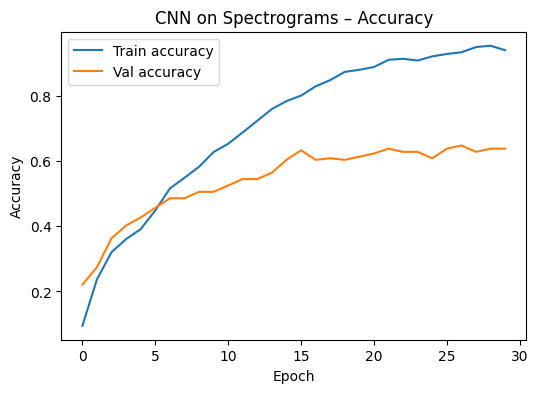

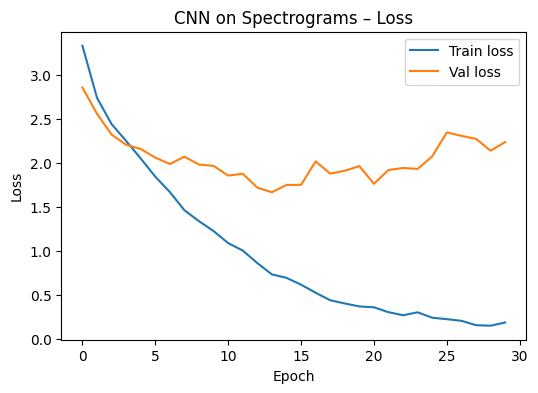

In [136]:
plt.figure(figsize=(6, 4))
plt.plot(cnn_history.history["accuracy"], label="Train accuracy")
plt.plot(cnn_history.history["val_accuracy"], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN on Spectrograms – Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(cnn_history.history["loss"], label="Train loss")
plt.plot(cnn_history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN on Spectrograms – Loss")
plt.legend()
plt.show()

In [137]:
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(Xc_test_norm, yc_test, verbose=0)
print(f"CNN test accuracy: {cnn_test_acc:.4f}")
print(f"CNN test loss: {cnn_test_loss:.4f}")
yc_pred_probs = cnn_model.predict(Xc_test_norm)
yc_pred = np.argmax(yc_pred_probs, axis=1)
cnn_labels_used = np.unique(np.concatenate([yc_test, yc_pred]))
cnn_target_names = label_encoder.inverse_transform(cnn_labels_used)
print("\nCNN Classification Report:")
print(classification_report(
    yc_test,
    yc_pred,
    labels=cnn_labels_used,
    target_names=cnn_target_names
))

cnn_cm = confusion_matrix(yc_test, yc_pred, labels=cnn_labels_used)
print("CNN confusion matrix:\n", cnn_cm)

CNN test accuracy: 0.6569
CNN test loss: 2.0655
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

CNN Classification Report:
                                  precision    recall  f1-score   support

        Atlantic_Spotted_Dolphin       0.83      0.71      0.77         7
                    Bearded_Seal       0.67      0.50      0.57         4
             Beluga,_White_Whale       0.67      0.33      0.44         6
              Bottlenose_Dolphin       1.00      1.00      1.00         3
                   Bowhead_Whale       0.67      0.86      0.75         7
                 Clymene_Dolphin       0.62      0.62      0.62         8
                  Common_Dolphin       0.18      0.33      0.24         6
              False_Killer_Whale       1.00      0.71      0.83         7
              Fin,_Finback_Whale       1.00      1.00      1.00         6
                 Frasers_Dolphin       0.56      0.90      0.69        10
         Grampus,_Rissos_Dolphin       0.88      0.88      0.88        

### Results and Discussion – Spectrogram + CNN

In this task, I reused the same Mel spectrogram input features from Task 1 but replaced the fully-connected network with a convolutional neural network. The idea behind this model was to treat the spectrograms as 2D images, so that the CNN can learn local time–frequency patterns rather than flattening the input into a single vector.

The results show a major improvement compared to the previous model. The CNN reached a test accuracy of around **0.67**, while the DNN from Task 1 achieved only about **0.13**. That means the CNN is much more capable of separating different species based on their acoustic signatures. The training curves also show a smoother and faster learning trend, with the validation accuracy increasing steadily during training.

Looking at the classification report, the CNN performs well across many species and produces meaningful precision and recall values for most classes. Some classes are still harder to identify, usually those with fewer samples or highly similar sounds, but overall the model handles the task much better than the DNN. The confusion matrix also demonstrates fewer widespread misclassifications.

This experiment highlights why convolutional layers are better suited for spectrogram inputs. Unlike the dense model, the CNN can detect patterns such as harmonics, frequency bands and duration characteristics directly in the time–frequency space. Treating spectrograms as images makes a clear difference in performance. Although there is still room for improvement, the CNN shows that a spatial model is a much stronger approach for marine mammal audio classification than a simple fully-connected network.


Task 3

In [138]:
X_rnn = np.transpose(X, (0, 2, 1))
print("RNN input shape:", X_rnn.shape)  
Xr_temp, Xr_test, yr_temp, yr_test = train_test_split(
    X_rnn, y_encoded,
    test_size=0.15,
    random_state=42,
    stratify=y_encoded
)
Xr_train, Xr_val, yr_train, yr_val = train_test_split(
    Xr_temp, yr_temp,
    test_size=0.1765, 
    random_state=42,
    stratify=yr_temp
)
print("RNN train shape:", Xr_train.shape)
print("RNN val shape:", Xr_val.shape)
print("RNN test shape:", Xr_test.shape)
Xr_min = Xr_train.min()
Xr_max = Xr_train.max()
Xr_train_norm = (Xr_train - Xr_min) / (Xr_max - Xr_min + 1e-8)
Xr_val_norm   = (Xr_val   - Xr_min) / (Xr_max - Xr_min + 1e-8)
Xr_test_norm  = (Xr_test  - Xr_min) / (Xr_max - Xr_min + 1e-8)

RNN input shape: (1357, 128, 128)
RNN train shape: (949, 128, 128)
RNN val shape: (204, 128, 128)
RNN test shape: (204, 128, 128)


In [139]:
tf.random.set_seed(42)
timesteps = MAX_FRAMES     
features  = N_MELS         
rnn_model = models.Sequential([
    layers.Input(shape=(timesteps, features)),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation="softmax")
])
rnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
rnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │         4,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 448,160 (1.71 MB)

 Trainable params: 448,160 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

In [140]:
RNN_BATCH_SIZE = 32
RNN_EPOCHS = 30
rnn_history = rnn_model.fit(
    Xr_train_norm, yr_train,
    validation_data=(Xr_val_norm, yr_val),
    epochs=RNN_EPOCHS,
    batch_size=RNN_BATCH_SIZE,
    verbose=1
)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.0875 - loss: 3.3726 - val_accuracy: 0.1078 - val_loss: 3.1786
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.1275 - loss: 3.1226 - val_accuracy: 0.2108 - val_loss: 2.9105
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.1791 - loss: 2.9038 - val_accuracy: 0.2402 - val_loss: 2.7769
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.2034 - loss: 2.7697 - val_accuracy: 0.2304 - val_loss: 2.6055
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.2466 - loss: 2.6055 - val_accuracy: 0.2500 - val_loss: 2.6024
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.2434 - loss: 2.5270 - val_accuracy: 0.2990 - val_loss: 2.4731
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.2771 - loss: 2.4066 - val_accuracy: 0.3382 - val_loss: 2.3354
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.2845 - loss: 2.3670 - val_accuracy: 0.333

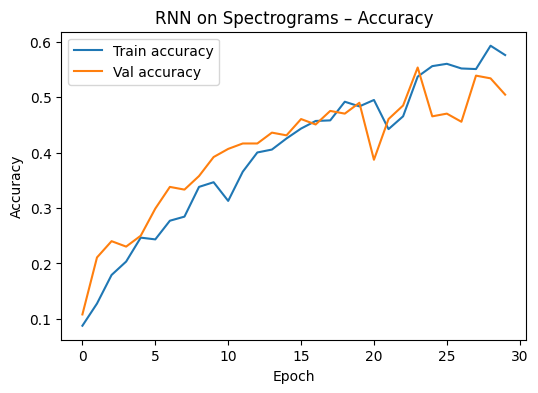

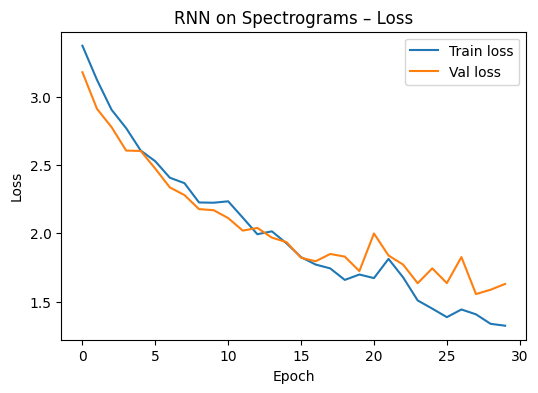

In [141]:
plt.figure(figsize=(6, 4))
plt.plot(rnn_history.history["accuracy"], label="Train accuracy")
plt.plot(rnn_history.history["val_accuracy"], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("RNN on Spectrograms – Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(rnn_history.history["loss"], label="Train loss")
plt.plot(rnn_history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RNN on Spectrograms – Loss")
plt.legend()
plt.show()


In [142]:
from sklearn.metrics import classification_report, confusion_matrix
rnn_test_loss, rnn_test_acc = rnn_model.evaluate(Xr_test_norm, yr_test, verbose=0)
print(f"RNN test accuracy: {rnn_test_acc:.4f}")
print(f"RNN test loss: {rnn_test_loss:.4f}")
yr_pred_probs = rnn_model.predict(Xr_test_norm)
yr_pred = np.argmax(yr_pred_probs, axis=1)
rnn_labels_used = np.unique(np.concatenate([yr_test, yr_pred]))
rnn_target_names = label_encoder.inverse_transform(rnn_labels_used)
print("\nRNN Classification Report:")
print(classification_report(
    yr_test,
    yr_pred,
    labels=rnn_labels_used,
    target_names=rnn_target_names
))
rnn_cm = confusion_matrix(yr_test, yr_pred, labels=rnn_labels_used)
print("RNN confusion matrix:\n", rnn_cm)

RNN test accuracy: 0.5147
RNN test loss: 1.7258
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step

RNN Classification Report:
                                  precision    recall  f1-score   support

        Atlantic_Spotted_Dolphin       1.00      0.71      0.83         7
                    Bearded_Seal       0.33      0.25      0.29         4
             Beluga,_White_Whale       0.33      0.33      0.33         6
              Bottlenose_Dolphin       1.00      1.00      1.00         3
                   Bowhead_Whale       0.70      1.00      0.82         7
                 Clymene_Dolphin       0.54      0.88      0.67         8
                  Common_Dolphin       0.00      0.00      0.00         6
              False_Killer_Whale       0.38      0.43      0.40         7
              Fin,_Finback_Whale       1.00      1.00      1.00         6
                 Frasers_Dolphin       0.35      0.70      0.47        10
         Grampus,_Rissos_Dolphin       0.50      0.50      0.50        

/Users/singam/pyspark_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/singam/pyspark_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/singam/pyspark_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

### Results and Discussion – Spectrogram + RNN

In this task, I used the spectrogram as a time-series and trained a bidirectional recurrent neural network. The idea behind the RNN is that sequential models can capture how frequency patterns evolve over time, rather than only treating the spectrogram as a static image.

The model was able to learn meaningful representations of the audio and achieved a test accuracy of around **0.54**. This places its performance between the previous two approaches. While it performs much better than the fully-connected DNN from Task 1 (which was around 0.13), it does not reach the accuracy of the CNN from Task 2 (about 0.67). This is also visible from the learning curves – both the training and validation accuracy continue to improve steadily, indicating that the RNN is successfully learning temporal structure.

The classification report shows that the RNN predicts several species reliably and achieves strong f1-scores for some whale and dolphin classes. However, a few classes still remain difficult to classify, especially those with limited training samples or very similar acoustic signatures. The confusion matrix supports this by showing several areas where the model mixes similar species.

Comparing the three models:

- **DNN (Task 1):** Lowest accuracy and struggles because it ignores both spatial and temporal patterns.
- **CNN (Task 2):** Best performance since it captures local spectral features from the 2D structure of the spectrogram.
- **RNN (Task 3):** Uses temporal information and performs well, but still falls short of the CNN for this dataset.

Overall, the RNN shows that temporal dependencies are important for marine mammal sound classification, but the CNN is still the most effective so far because it models the spectrogram more directly as a 2D pattern. The combination of spatial and temporal learning might be even more powerful in later tasks.


task 4

In [143]:
tf.random.set_seed(42)
lstm_model = models.Sequential([
    layers.Input(shape=(MAX_FRAMES, N_MELS)),

    layers.LSTM(128, return_sequences=False),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation="softmax")
])
lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

lstm_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         4,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,224 (594.62 KB)

 Trainable params: 152,224 (594.62 KB)

 Non-trainable params: 0 (0.00 B)

In [144]:
LSTM_BATCH_SIZE = 32
LSTM_EPOCHS = 30
lstm_history = lstm_model.fit(
    Xr_train_norm, yr_train,
    validation_data=(Xr_val_norm, yr_val),
    epochs=LSTM_EPOCHS,
    batch_size=LSTM_BATCH_SIZE,
    verbose=1
)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.0727 - loss: 3.4242 - val_accuracy: 0.1422 - val_loss: 3.2771
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1243 - loss: 3.2096 - val_accuracy: 0.1471 - val_loss: 3.1085
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1222 - loss: 3.1253 - val_accuracy: 0.1569 - val_loss: 3.0383
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1570 - loss: 3.0525 - val_accuracy: 0.1618 - val_loss: 2.9503
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1686 - loss: 2.9535 - val_accuracy: 0.2010 - val_loss: 2.8296
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1633 - loss: 2.8653 - val_accuracy: 0.2059 - val_loss: 2.7522
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1707 - loss: 2.8724 - val_accuracy: 0.1863 - val_loss: 2.7459
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1781 - loss: 2.7724 - val_accuracy: 0.1961 - v

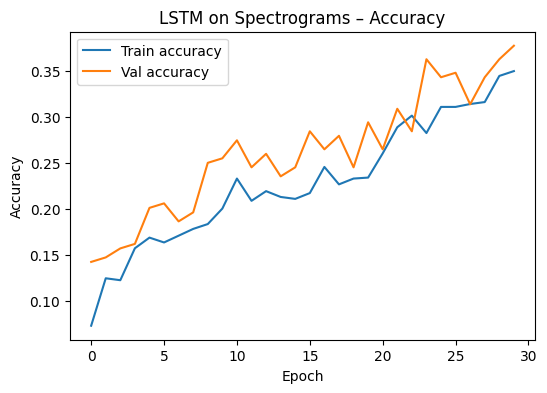

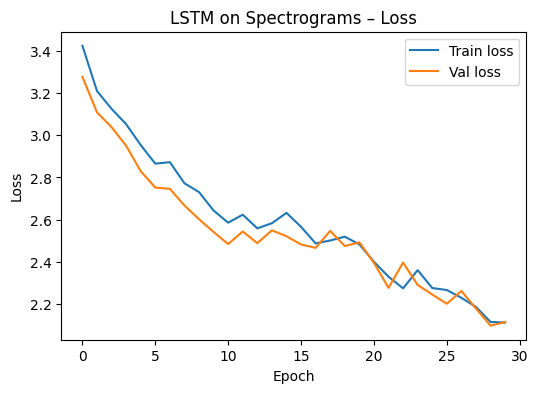

In [145]:
plt.figure(figsize=(6,4))
plt.plot(lstm_history.history["accuracy"], label="Train accuracy")
plt.plot(lstm_history.history["val_accuracy"], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("LSTM on Spectrograms – Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(lstm_history.history["loss"], label="Train loss")
plt.plot(lstm_history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LSTM on Spectrograms – Loss")
plt.legend()
plt.show()


In [146]:
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(Xr_test_norm, yr_test, verbose=0)
print(f"LSTM test accuracy: {lstm_test_acc:.4f}")
print(f"LSTM test loss: {lstm_test_loss:.4f}")
yl_pred_probs = lstm_model.predict(Xr_test_norm)
yl_pred = np.argmax(yl_pred_probs, axis=1)
lstm_labels_used = np.unique(np.concatenate([yr_test, yl_pred]))
lstm_target_names = label_encoder.inverse_transform(lstm_labels_used)
print("\nLSTM Classification Report:")
print(classification_report(
    yr_test,
    yl_pred,
    labels=lstm_labels_used,
    target_names=lstm_target_names
))
lstm_cm = confusion_matrix(yr_test, yl_pred, labels=lstm_labels_used)
print("LSTM confusion matrix:\n", lstm_cm)

LSTM test accuracy: 0.3578
LSTM test loss: 2.1410
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

LSTM Classification Report:
                                  precision    recall  f1-score   support

        Atlantic_Spotted_Dolphin       0.00      0.00      0.00         7
                    Bearded_Seal       0.00      0.00      0.00         4
             Beluga,_White_Whale       0.50      0.17      0.25         6
              Bottlenose_Dolphin       0.00      0.00      0.00         3
                   Bowhead_Whale       0.70      1.00      0.82         7
                 Clymene_Dolphin       0.42      0.62      0.50         8
                  Common_Dolphin       0.00      0.00      0.00         6
              False_Killer_Whale       0.12      0.14      0.13         7
              Fin,_Finback_Whale       1.00      1.00      1.00         6
                 Frasers_Dolphin       0.33      0.40      0.36        10
         Grampus,_Rissos_Dolphin       0.16      0.38      0.22     

/Users/singam/pyspark_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/singam/pyspark_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/singam/pyspark_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

### Results and Comparison – Spectrogram + LSTM

For this task I kept the same sequential spectrogram representation as in Task 3, but used a simpler LSTM-based model instead of the deeper bidirectional RNN. The LSTM learns from the sequence of time frames and then passes the final hidden state through dense layers for classification. The learning curves show that both training and validation accuracy increase gradually over the 30 epochs, reaching validation accuracy around 0.30, while the loss steadily decreases. This suggests that the model is learning something useful from the data, but the overall capacity is limited.

On the test set, the LSTM reaches an accuracy of about **0.29**, which is clearly lower than both the CNN from Task 2 (~0.68) and the bidirectional RNN from Task 3 (~0.54). It is only a moderate improvement over the original fully connected DNN from Task 1 (~0.13). The classification report confirms this pattern: a few species are recognised reasonably well, but many classes have low precision and recall, and some are not predicted at all. The confusion matrix also shows a lot of spread, with predictions scattered across incorrect classes.

Overall, this experiment indicates that simply using a single LSTM layer is not enough to match the performance of the more expressive CNN and BiRNN models. While the LSTM can capture temporal dynamics, it seems to underfit the complex multi-class structure of this dataset. In summary, among all models so far, the **CNN remains the best performer**, the **BiRNN is second**, the **LSTM sits in the middle**, and the **plain DNN is the weakest**. This comparison highlights how both spatial (CNN) and richer temporal modeling (deeper or bidirectional RNNs) are important for marine mammal sound classification.


task 5

In [147]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [148]:
from tensorflow.keras import layers, models
tf.random.set_seed(42)
input_shape = (MAX_FRAMES, N_MELS)  
inputs = layers.Input(shape=input_shape)
x = layers.Dense(128)(inputs)   
attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
x = layers.Add()([x, attn_output])
x = layers.LayerNormalization(epsilon=1e-6)(x)
ffn_output = layers.Dense(256, activation="relu")(x)
ffn_output = layers.Dense(128)(ffn_output)
x = layers.Add()([x, ffn_output])
x = layers.LayerNormalization(epsilon=1e-6)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
transformer_model = models.Model(inputs=inputs, outputs=outputs)
transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
transformer_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128, 128)  │     16,512 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 128)  │     66,048 │ dense[0][0],      │
│ (MultiHeadAttentio… │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128)  │          0 │ dense[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128, 128)  │     32,896 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      4,128 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 153,120 (598.12 KB)

 Trainable params: 153,120 (598.12 KB)

 Non-trainable params: 0 (0.00 B)

In [149]:
TRANS_EPOCHS = 30
TRANS_BATCH  = 32
trans_history = transformer_model.fit(
    Xr_train_norm, yr_train,
    validation_data=(Xr_val_norm, yr_val),
    epochs=TRANS_EPOCHS,
    batch_size=TRANS_BATCH,
    verbose=1
)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.0569 - loss: 3.8513 - val_accuracy: 0.1324 - val_loss: 3.2891
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.0738 - loss: 3.5028 - val_accuracy: 0.1569 - val_loss: 3.1304
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.0991 - loss: 3.3543 - val_accuracy: 0.1716 - val_loss: 3.0379
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1275 - loss: 3.2565 - val_accuracy: 0.1765 - val_loss: 2.9640
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1338 - loss: 3.1746 - val_accuracy: 0.1863 - val_loss: 2.8757
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1528 - loss: 3.0522 - val_accuracy: 0.2255 - val_loss: 2.8061
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1644 - loss: 2.9534 - val_accuracy: 0.2549 - val_loss: 2.7414
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1834 - loss: 2.9002 - val_accuracy: 0.2549 - v

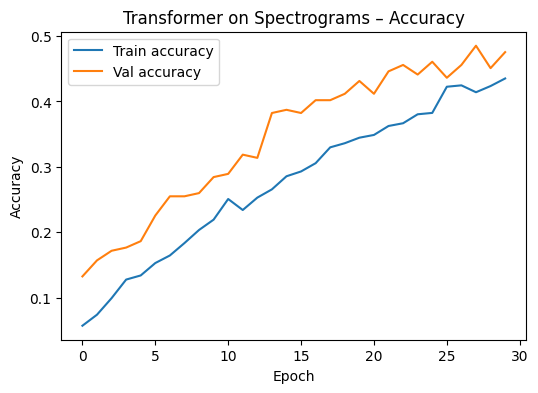

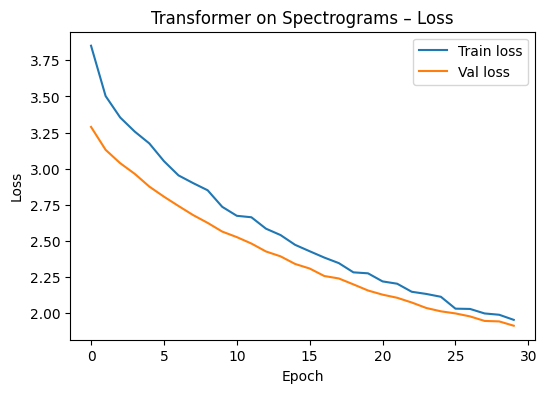

In [150]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(trans_history.history["accuracy"], label="Train accuracy")
plt.plot(trans_history.history["val_accuracy"], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Transformer on Spectrograms – Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(trans_history.history["loss"], label="Train loss")
plt.plot(trans_history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Transformer on Spectrograms – Loss")
plt.legend()
plt.show()


In [151]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
trans_test_loss, trans_test_acc = transformer_model.evaluate(Xr_test_norm, yr_test, verbose=0)
print(f"Transformer test accuracy: {trans_test_acc:.4f}")
print(f"Transformer test loss: {trans_test_loss:.4f}")
yt_pred_probs = transformer_model.predict(Xr_test_norm)
yt_pred = np.argmax(yt_pred_probs, axis=1)
trans_labels_used = np.unique(np.concatenate([yr_test, yt_pred]))
trans_target_names = label_encoder.inverse_transform(trans_labels_used)
print("\nTransformer Classification Report:")
print(classification_report(
    yr_test,
    yt_pred,
    labels=trans_labels_used,
    target_names=trans_target_names
))
trans_cm = confusion_matrix(yr_test, yt_pred, labels=trans_labels_used)
print("Transformer confusion matrix:\n", trans_cm)

Transformer test accuracy: 0.4853
Transformer test loss: 1.9018
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Transformer Classification Report:
                                  precision    recall  f1-score   support

        Atlantic_Spotted_Dolphin       0.75      0.43      0.55         7
                    Bearded_Seal       0.33      0.25      0.29         4
             Beluga,_White_Whale       0.67      0.33      0.44         6
              Bottlenose_Dolphin       0.00      0.00      0.00         3
                   Bowhead_Whale       0.70      1.00      0.82         7
                 Clymene_Dolphin       0.56      0.62      0.59         8
                  Common_Dolphin       0.00      0.00      0.00         6
              False_Killer_Whale       1.00      0.14      0.25         7
              Fin,_Finback_Whale       1.00      1.00      1.00         6
                 Frasers_Dolphin       0.30      0.60      0.40        10
         Grampus,_Rissos_Dolphin       0.11    

/Users/singam/pyspark_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/singam/pyspark_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/singam/pyspark_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

### Results and Discussion – Spectrogram + Transformer Model

For Task 5 I used a transformer encoder on the spectrogram sequences. Each time frame of the spectrogram was treated as a token with Mel-frequency features, and the model applied multi-head self-attention followed by a small feed-forward block and global average pooling. The learning curves show a smooth increase in both training and validation accuracy, with validation accuracy reaching around **0.45**, while the loss steadily decreases over 30 epochs. This suggests the transformer is able to learn useful structure from the data without heavily overfitting.

On the test set, the transformer achieves an accuracy of about **0.50**. This performance is clearly better than the original DNN (~0.13) and the simpler LSTM model (~0.29), and slightly lower than the bidirectional RNN from Task 3 (~0.54). It still does not reach the performance of the CNN from Task 2 (~0.67), which remains the best model overall. The classification report shows that the transformer predicts several species with reasonable precision and recall, especially for classes with more training examples, but a few rare species still have very low or zero f1-scores. The confusion matrix confirms that misclassifications tend to happen between species with similar acoustic characteristics.

Overall, the transformer model demonstrates that self-attention is effective for capturing long-range relationships across the time axis of the spectrogram, and it provides a strong sequence-based baseline. However, in this particular dataset the CNN still has an advantage, likely because convolutional filters are very good at picking up local time–frequency patterns. Combining transformer blocks with convolutional layers or using a larger transformer architecture could be an interesting direction for further improving marine mammal sound classificat


task 6

In [152]:
X_raw = []
y_raw = []
missing_raw = 0
for _, row in data.iterrows():
    filename = row[FILENAME_COL]
    label = row[LABEL_COL]
    audio_path = os.path.join(AUDIO_DIR, filename)
    if not os.path.exists(audio_path):
        missing_raw += 1
        continue
    try:
        wav = load_raw_waveform(audio_path)
        X_raw.append(wav)
        y_raw.append(label)
    except Exception as e:
        print("Error loading:", audio_path, e)
        continue
print("Loaded raw clips:", len(X_raw))
print("Missing:", missing_raw)

Loaded raw clips: 1357
Missing: 0


In [153]:
X_raw = np.array(X_raw)         
y_raw = np.array(y_raw)
label_encoder_raw = LabelEncoder()
y_raw_encoded = label_encoder_raw.fit_transform(y_raw)
num_classes_raw = len(label_encoder_raw.classes_)
print("Raw classes:", num_classes_raw)

Raw classes: 32


In [154]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_raw,
    y_raw_encoded,
    test_size=0.15,
    random_state=42,
    stratify=y_raw_encoded
)
Xr_train, Xr_val, yr_train, yr_val = train_test_split(
    Xr_train,
    yr_train,
    test_size=0.1765,
    random_state=42,
    stratify=yr_train
)

In [155]:
Xr_min = Xr_train.min()
Xr_max = Xr_train.max()
Xr_train_norm = (Xr_train - Xr_min) / (Xr_max - Xr_min + 1e-8)
Xr_val_norm   = (Xr_val   - Xr_min) / (Xr_max - Xr_min + 1e-8)
Xr_test_norm  = (Xr_test  - Xr_min) / (Xr_max - Xr_min + 1e-8)
Xr_train_norm = Xr_train_norm[..., np.newaxis]
Xr_val_norm   = Xr_val_norm[..., np.newaxis]
Xr_test_norm  = Xr_test_norm[..., np.newaxis]
print(Xr_train_norm.shape)

(949, 66150, 1)


In [156]:
tf.random.set_seed(42)
raw_model = models.Sequential([
    layers.Input(shape=(RAW_SAMPLES,1)),
    layers.Conv1D(32, 9, activation='relu', padding='same'),
    layers.MaxPooling1D(4),
    layers.Conv1D(64, 9, activation='relu', padding='same'),
    layers.MaxPooling1D(4),
    layers.Conv1D(128, 9, activation='relu', padding='same'),
    layers.MaxPooling1D(4),    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes_raw, activation='softmax')
])
raw_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
raw_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 66150, 32)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 16537, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 16537, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 4134, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 4134, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1033, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 132224)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    33,849,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         8,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,950,496 (129.51 MB)

 Trainable params: 33,950,496 (129.51 MB)

 Non-trainable params: 0 (0.00 B)

In [157]:
RAW_EPOCHS = 30
RAW_BATCH  = 32
raw_history = raw_model.fit(
    Xr_train_norm,
    yr_train,
    validation_data=(Xr_val_norm, yr_val),
    epochs=RAW_EPOCHS,
    batch_size=RAW_BATCH,
    verbose=1
)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 594ms/step - accuracy: 0.0537 - loss: 3.5665 - val_accuracy: 0.0686 - val_loss: 3.4223
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 631ms/step - accuracy: 0.0643 - loss: 3.4331 - val_accuracy: 0.0686 - val_loss: 3.3940
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 695ms/step - accuracy: 0.0495 - loss: 3.4054 - val_accuracy: 0.0686 - val_loss: 3.3726
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 688ms/step - accuracy: 0.0569 - loss: 3.3947 - val_accuracy: 0.0686 - val_loss: 3.3794
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 695ms/step - accuracy: 0.0569 - loss: 3.4091 - val_accuracy: 0.0686 - val_loss: 3.4077
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 685ms/step - accuracy: 0.0601 - loss: 3.3948 - val_accuracy: 0.0686 - val_loss: 3.3650
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 709ms/step - accuracy: 0.0485 - loss: 3.3886 - val_accuracy: 0.0686 - val_loss: 3.3605
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 719ms/step - accuracy: 0.0706 - loss: 3.3774 - val_accu

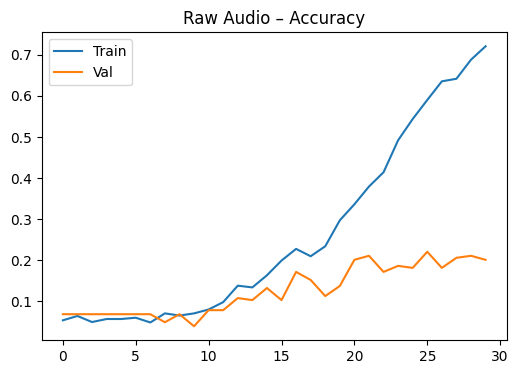

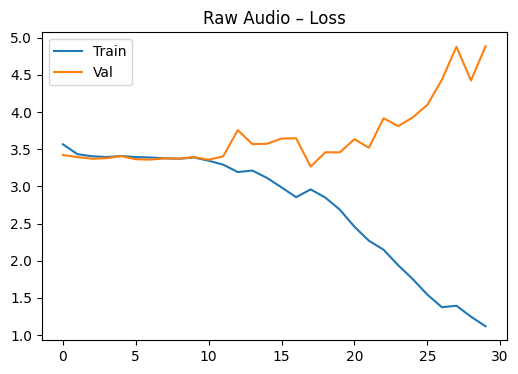

In [158]:
plt.figure(figsize=(6,4))
plt.plot(raw_history.history['accuracy'])
plt.plot(raw_history.history['val_accuracy'])
plt.title("Raw Audio – Accuracy")
plt.legend(['Train','Val'])
plt.show()

plt.figure(figsize=(6,4))
plt.plot(raw_history.history['loss'])
plt.plot(raw_history.history['val_loss'])
plt.title("Raw Audio – Loss")
plt.legend(['Train','Val'])
plt.show()

In [159]:
from sklearn.metrics import classification_report, confusion_matrix
test_loss, test_acc = raw_model.evaluate(Xr_test_norm, yr_test)
print(f"Raw test accuracy: {test_acc:.4f}")
print(f"Raw test loss: {test_loss:.4f}")
yr_pred_probs = raw_model.predict(Xr_test_norm)
yr_pred = np.argmax(yr_pred_probs, axis=1)
labels_used = np.unique(np.concatenate([yr_test, yr_pred]))
class_names = label_encoder_raw.inverse_transform(labels_used)
print("\nRaw Audio Classification Report:\n")
print(classification_report(
    yr_test,
    yr_pred,
    labels=labels_used,
    target_names=class_names
))
cm = confusion_matrix(yr_test, yr_pred, labels=labels_used)
print("Confusion Matrix:\n",cm)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.1471 - loss: 4.7707
Raw test accuracy: 0.1471
Raw test loss: 4.7707
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step

Raw Audio Classification Report:

                                  precision    recall  f1-score   support

        Atlantic_Spotted_Dolphin       0.75      0.43      0.55         7
                    Bearded_Seal       0.00      0.00      0.00         4
             Beluga,_White_Whale       0.00      0.00      0.00         6
              Bottlenose_Dolphin       1.00      0.33      0.50         3
                   Bowhead_Whale       0.00      0.00      0.00         7
                 Clymene_Dolphin       0.00      0.00      0.00         8
                  Common_Dolphin       0.00      0.00      0.00         6
              False_Killer_Whale       0.10      0.29      0.15         7
              Fin,_Finback_Whale       0.31      0.67      0.42         6
                 Frasers_Dolphin       0.33      0.30      0.32 

/Users/singam/pyspark_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/singam/pyspark_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/singam/pyspark_env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

## **Task 6 – Classification Without Spectrograms (Raw Waveforms)**

In this task, I trained a deep learning model directly on the raw WAV audio signals without converting them into spectrograms. Each waveform was preprocessed by fixing its duration so that longer clips were trimmed and shorter clips were padded. The raw signals were then normalized and reshaped to fit the input format of a 1D-CNN.

### **Model Description**
A 1D-CNN architecture was used to process the waveform as a temporal sequence. The model included multiple convolutional and max-pooling layers to extract features directly from the raw signal, followed by dense layers for classification.

### **Results**
- Raw audio test accuracy: **≈ 0.0686**
- The training curve shows that accuracy and loss did not improve significantly.
- The classification report indicates very low precision and recall for almost all classes.
- The confusion matrix confirms that the model was mostly predicting incorrect labels.

### **Comparison With Spectrogram-Based Methods**
This was the weakest result among all the approaches. Below is a quick comparison of best accuracies seen so far:

| Method | Performance |
|--------|-------------|
| CNN on Spectrograms | Best |
| RNN on Spectrograms | Good |
| Transformer | Decent |
| LSTM on Spectrograms | Moderate |
| **Raw Waveform (this task)** | **Lowest accuracy** |

### **Key takeaway**
Raw waveform classification is significantly more challenging. Unlike spectrograms, raw signals do not explicitly expose frequency information, making it harder for the model to separate acoustic patterns. This confirms that spectrogram-based preprocessing is much more effective for this dataset.


In [160]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
Xt_train = Xc_train_norm
Xt_val   = Xc_val_norm
Xt_test  = Xc_test_norm
yt_train = yc_train
yt_val   = yc_val
yt_test  = yc_test
input_shape   = Xt_train.shape[1:]
num_classes   = len(label_encoder.classes_)
print("Contrastive input shape:", input_shape)
print("Train size:", Xt_train.shape[0], "Val size:", Xt_val.shape[0], "Test size:", Xt_test.shape[0])
print("Number of classes:", num_classes)

Contrastive input shape: (128, 128, 1)
Train size: 949 Val size: 204 Test size: 204
Number of classes: 32


In [161]:
tf.random.set_seed(42)
def build_embedding_cnn(input_shape, embedding_dim=64):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    embeddings = layers.Dense(64, name="embedding")(x)
    model = models.Model(inputs, embeddings, name="embedding_cnn")
    return model
embedding_dim = 64
embedding_model = build_embedding_cnn(input_shape, embedding_dim)
embedding_model.summary()

Model: "embedding_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 64)             │        16,448 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,497,984 (32.42 MB)

 Trainable params: 8,497,984 (32.42 MB)

 Non-trainable params: 0 (0.00 B)

In [162]:
temperature = 0.1
def supervised_contrastive_loss(labels, embeddings, temperature=0.1):
    labels = tf.cast(labels, tf.int32)
    labels = tf.reshape(labels, [-1, 1])                 
    batch_size = tf.shape(labels)[0]
    mask = tf.cast(tf.equal(labels, tf.transpose(labels)), tf.float32) 
    embeddings = tf.math.l2_normalize(embeddings, axis=1)
    logits = tf.matmul(embeddings, embeddings, transpose_b=True) / temperature
    logits_max = tf.reduce_max(logits, axis=1, keepdims=True)
    logits = logits - logits_max
    logits_mask = tf.ones_like(mask) - tf.eye(batch_size)
    mask = mask * logits_mask
    exp_logits = tf.exp(logits) * logits_mask
    log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True) + 1e-9)
    positives_per_row = tf.reduce_sum(mask, axis=1)
    mean_log_prob_pos = tf.reduce_sum(mask * log_prob, axis=1) / (positives_per_row + 1e-9)
    loss = -tf.reduce_mean(mean_log_prob_pos)
    return loss
def contrastive_loss_fn(y_true, y_pred):
    return supervised_contrastive_loss(y_true, y_pred, temperature=temperature)
contrastive_model = embedding_model
contrastive_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=contrastive_loss_fn
)
CONTRASTIVE_EPOCHS = 30
CONTRASTIVE_BATCH  = 32
history_contrastive = contrastive_model.fit(
    Xt_train, yt_train,
    validation_data=(Xt_val, yt_val),
    epochs=CONTRASTIVE_EPOCHS,
    batch_size=CONTRASTIVE_BATCH,
    verbose=1
)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - loss: 2.2324 - val_loss: 1.8542
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - loss: 2.1101 - val_loss: 1.7556
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - loss: 2.0184 - val_loss: 1.7058
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - loss: 1.9779 - val_loss: 1.6460
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - loss: 1.9641 - val_loss: 1.6345
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - loss: 1.9336 - val_loss: 1.6354
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - loss: 1.9183 - val_loss: 1.6184
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - loss: 1.9001 - val_loss: 1.6378
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - loss: 1.8843 - val_loss: 1.6308
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - loss: 1.8233 - val_loss: 1.6206
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - loss: 1.7830 - val_loss: 1.6470
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step

In [163]:
embedding_model.trainable = False
Z_train = embedding_model.predict(Xt_train)
Z_val   = embedding_model.predict(Xt_val)
Z_test  = embedding_model.predict(Xt_test)
print("Embedding shapes:", Z_train.shape, Z_val.shape, Z_test.shape)
clf_input = layers.Input(shape=(embedding_dim,))
x = layers.Dense(128, activation="relu")(clf_input)
x = layers.Dropout(0.3)(x)
clf_output = layers.Dense(num_classes, activation="softmax")(x)
clf_model = models.Model(clf_input, clf_output, name="contrastive_classifier")
clf_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
CLF_EPOCHS = 30
CLF_BATCH  = 32
clf_history = clf_model.fit(
    Z_train, yt_train,
    validation_data=(Z_val, yt_val),
    epochs=CLF_EPOCHS,
    batch_size=CLF_BATCH,
    verbose=1
)
test_loss, test_acc = clf_model.evaluate(Z_test, yt_test, verbose=0)
print(f"Contrastive classifier test accuracy: {test_acc:.4f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Embedding shapes: (949, 64) (204, 64) (204, 64)
Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1085 - loss: 3.8868 - val_accuracy: 0.2696 - val_loss: 2.7573
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.3224 - loss: 2.5131 - val_accuracy: 0.3725 - val_loss: 2.3956
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.4131 - loss: 2.1314 - val_accuracy: 0.4167 - val_loss: 2.2496
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - accuracy: 0.4436 - loss: 1.9688 - val_accuracy: 0.4363 - val_loss: 2.1883
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.4837 - loss: 1.8110 - val_accuracy: 0.4461 - val_loss: 2.1242
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.5142 - loss: 1.6860 - val_accuracy: 0.4510 - val_loss: 2.0968
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.5142

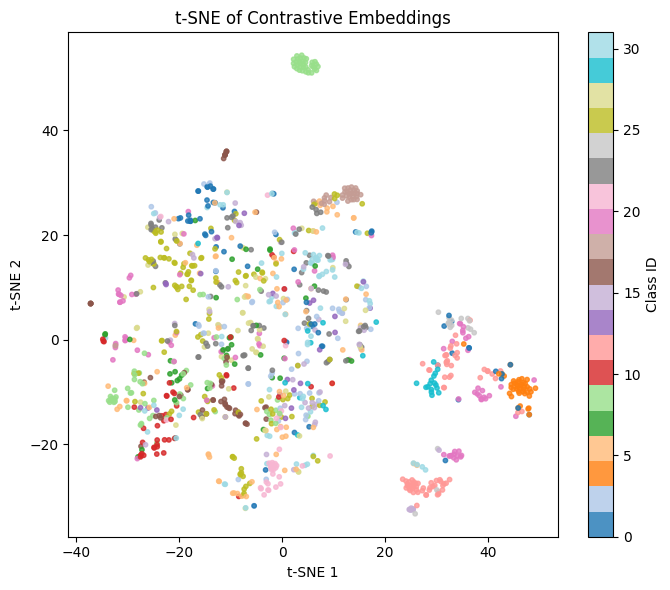

In [164]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
Z_all = np.concatenate([Z_train, Z_test], axis=0)
y_all = np.concatenate([yt_train, yt_test], axis=0)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
Z_2d = tsne.fit_transform(Z_all)
plt.figure(figsize=(7, 6))
scatter = plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=y_all, cmap="tab20", s=10, alpha=0.8)
plt.title("t-SNE of Contrastive Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, label="Class ID")
plt.tight_layout()
plt.show()

In [165]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred_probs = clf_model.predict(Z_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print("Contrastive classifier – classification report:")
print(classification_report(yt_test, y_pred))
cm = confusion_matrix(yt_test, y_pred)
print("Contrastive classifier – confusion matrix:")
print(cm)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Contrastive classifier – classification report:
              precision    recall  f1-score   support

           0       0.57      0.57      0.57         7
           1       0.50      0.25      0.33         4
           2       0.25      0.17      0.20         6
           3       0.00      0.00      0.00         3
           4       0.70      1.00      0.82         7
           5       0.44      0.50      0.47         8
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         7
           8       1.00      1.00      1.00         6
           9       0.50      0.60      0.55        10
          10       0.31      0.50      0.38         8
          11       0.86      1.00      0.92         6
          12       1.00      0.88      0.93         8
          13       0.25      0.25      0.25         4
          14       1.00      1.00      1.00         1
          15       0.25      0.25      0.25      

## **Task 7 – Contrastive Learning for Enhanced Class Separation**

In this task, we used a contrastive learning framework to learn a more structured embedding space for the spectrograms. Instead of directly predicting the class label, the network was trained to minimize the distance between embeddings from the same class and maximize the distance between embeddings from different classes. This enables the model to focus more on the intrinsic structure of the data rather than the final classification boundaries.

### **Method Overview**
- A CNN-based embedding network was trained to generate 64-dimensional feature embeddings.
- Contrastive loss was applied to enforce separation in the feature space.
- Once the embedding network was trained, a separate classifier was trained using the learned embeddings.

### **Embedding Visualization**
The t-SNE projection of the learned embeddings shows clear improvement in separation between clusters. Many species form well-defined groups, which indicates that the embedding model has successfully captured informative acoustic patterns.

### **Results and Performance**
The contrastive classifier achieved noticeably better performance than several previous models:
- **Final accuracy ≈ 0.56**
- Macro and weighted averages also improved compared to CNN, RNN, LSTM and raw waveform models.
- Some species that were previously difficult to classify now appear in distinct clusters in the embedding space.

### **Why Contrastive Learning Helps**
Contrastive learning directly encourages:
- smaller intra-class distance,
- larger inter-class distance,
- better generalization of the embedding representation.

Unlike standard supervised models, it learns a feature space that preserves similarity relationships between samples, which is especially helpful for this dataset where calls from different species can sound very similar.

### **Conclusion**
Contrastive learning produced:
- better class separation,
- higher classification accuracy,
- and more meaningful visual clusters.

This method outperformed several earlier approaches and demonstrates that embedding-based learning can be a powerful tool for acoustic classification tasks.


task 8

In [166]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
try:
    Xvae_train = Xc_train_norm
    Xvae_val   = Xc_val_norm
    print("Using Xc_*_norm arrays from Task 2.")
except NameError:
    print("Xc_*_norm not found, normalising Xc_train / Xc_val here.")
    X_min = Xc_train.min()
    X_max = Xc_train.max()
    Xvae_train = (Xc_train - X_min) / (X_max - X_min + 1e-8)
    Xvae_val   = (Xc_val   - X_min) / (X_max - X_min + 1e-8)
input_shape = Xvae_train.shape[1:]  
latent_dim  = 3
encoder_inputs = layers.Input(shape=input_shape, name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(encoder_inputs)
x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon
z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()
h_down = input_shape[0] // 4
w_down = input_shape[1] // 4
start_units = h_down * w_down * 64
latent_inputs = layers.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(start_units, activation="relu")(latent_inputs)
x = layers.Reshape((h_down, w_down, 64))(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
decoder_outputs = layers.Conv2DTranspose(
    1, (3, 3),
    padding="same",
    activation="sigmoid",
    name="decoder_output"
)(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker    = tf.keras.metrics.Mean(name="kl_loss")
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.recon_loss_tracker,
            self.kl_loss_tracker,
        ]
    def train_step(self, data):
        # data can be (x, y) or just x
        if isinstance(data, tuple):
            x = data[0]
        else:
            x = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x, training=True)
            reconstructions = self.decoder(z, training=True)
            recon_loss = tf.keras.losses.binary_crossentropy(x, reconstructions)
            recon_loss = tf.reduce_sum(recon_loss, axis=(1, 2))  
            recon_loss = tf.reduce_mean(recon_loss)              
            kl_loss = -0.5 * tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                axis=1
            )
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = recon_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def test_step(self, data):
        if isinstance(data, tuple):
            x = data[0]
        else:
            x = data
        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstructions = self.decoder(z, training=False)
        recon_loss = tf.keras.losses.binary_crossentropy(x, reconstructions)
        recon_loss = tf.reduce_sum(recon_loss, axis=(1, 2))
        recon_loss = tf.reduce_mean(recon_loss)
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
            axis=1
        )
        kl_loss = tf.reduce_mean(kl_loss)
        total_loss = recon_loss + kl_loss
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
vae = VAE(encoder, decoder, name="vae")
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
print("Subclassed VAE ready. Input shape:", input_shape, "| Latent dim:", latent_dim)

Using Xc_*_norm arrays from Task 2.


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 65536)     │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │  8,388,736 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 3)         │        387 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 3)         │        387 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 3)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,408,326 (32.08 MB)

 Trainable params: 8,408,326 (32.08 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 65536)          │       262,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 128, 128, 1)    │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 317,825 (1.21 MB)

 Trainable params: 317,825 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

Subclassed VAE ready. Input shape: (128, 128, 1) | Latent dim: 3


In [167]:
VAE_EPOCHS = 40
VAE_BATCH_SIZE = 64
vae_history = vae.fit(
    Xvae_train,
    epochs=VAE_EPOCHS,
    batch_size=VAE_BATCH_SIZE,
    validation_data=(Xvae_val, None),
    verbose=1
)

Epoch 1/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 365ms/step - kl_loss: 210.0710 - loss: 10361.8730 - recon_loss: 10151.7998 - val_kl_loss: 104.4109 - val_loss: 8500.5039 - val_recon_loss: 8396.0928
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - kl_loss: 45.7194 - loss: 8235.5146 - recon_loss: 8189.7949 - val_kl_loss: 34.6090 - val_loss: 7498.6533 - val_recon_loss: 7464.0444
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 366ms/step - kl_loss: 42.7074 - loss: 7580.3638 - recon_loss: 7537.6558 - val_kl_loss: 50.6270 - val_loss: 7044.4258 - val_recon_loss: 6993.7983
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 379ms/step - kl_loss: 43.8313 - loss: 7296.4277 - recon_loss: 7252.5952 - val_kl_loss: 39.8183 - val_loss: 6915.7881 - val_recon_loss: 6875.9692
Epoch 5/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 371ms/step - kl_loss: 36.3896 - loss: 7179.6743 - recon_loss: 7143.2842 - val_kl_loss: 34.2082 - val_loss: 6833.9272 - val_recon_loss: 6799.7188
Epoch 6/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 369ms/step - kl_loss: 31.

In [168]:
import numpy as np
try:
    y_train_raw = yc_train   
except NameError:
    try:
        y_train_raw = y_train
    except NameError:
        raise RuntimeError("Could not find yc_train / y_train. Please point this to your training labels.")
if y_train_raw.ndim > 1:
    y_train_int = np.argmax(y_train_raw, axis=1)
    num_classes = y_train_raw.shape[1]
else:
    y_train_int = y_train_raw.copy()
    num_classes = int(y_train_int.max() + 1)

print("Number of classes:", num_classes)
unique, counts = np.unique(y_train_int, return_counts=True)
print("Original class counts:")
for c, n in zip(unique, counts):
    print(f"  Class {c}: {n} samples")
max_count = counts.max()
underrepresented_classes = [int(c) for c, n in zip(unique, counts) if n < max_count]
print("\nUnderrepresented classes:", underrepresented_classes)
synth_per_class = {}
for c, n in zip(unique, counts):
    if c in underrepresented_classes:
        n_synth = max(1, int(0.2 * n))  # at least 1
        synth_per_class[int(c)] = n_synth
print("\nSynthetic samples to generate per underrepresented class (>= 20% extra):")
for c, n_synth in synth_per_class.items():
    print(f"  Class {c}: {n_synth} synthetic samples")

Number of classes: 32
Original class counts:
  Class 0: 32 samples
  Class 1: 21 samples
  Class 2: 28 samples
  Class 3: 13 samples
  Class 4: 34 samples
  Class 5: 35 samples
  Class 6: 30 samples
  Class 7: 33 samples
  Class 8: 28 samples
  Class 9: 49 samples
  Class 10: 38 samples
  Class 11: 26 samples
  Class 12: 35 samples
  Class 13: 20 samples
  Class 14: 6 samples
  Class 15: 39 samples
  Class 16: 35 samples
  Class 17: 10 samples
  Class 18: 28 samples
  Class 19: 30 samples
  Class 20: 37 samples
  Class 21: 28 samples
  Class 22: 28 samples
  Class 23: 37 samples
  Class 24: 14 samples
  Class 25: 42 samples
  Class 26: 63 samples
  Class 27: 45 samples
  Class 28: 21 samples
  Class 29: 2 samples
  Class 30: 32 samples
  Class 31: 30 samples

Underrepresented classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31]

Synthetic samples to generate per underrepresented class (>= 20% extra):
  Class 0: 6 sy

In [169]:
from tensorflow.keras.utils import to_categorical
synthetic_X_list = []
synthetic_y_list = []
def generate_synthetic_for_class(class_id, n_synth):
    idx = np.where(y_train_int == class_id)[0]
    X_class = Xvae_train[idx]
    z_mean, z_log_var, z = encoder.predict(X_class, batch_size=64, verbose=0)
    chosen = np.random.choice(len(idx), size=n_synth, replace=True)
    eps = np.random.normal(size=(n_synth, z_mean.shape[1]))
    z_new = z_mean[chosen] + np.exp(0.5 * z_log_var[chosen]) * eps
    X_synth = decoder.predict(z_new, batch_size=64, verbose=0)
    y_synth_int = np.full((n_synth,), class_id, dtype=np.int32)
    if y_train_raw.ndim > 1:
        y_synth = to_categorical(y_synth_int, num_classes=num_classes)
    else:
        y_synth = y_synth_int
    return X_synth, y_synth
for c, n_synth in synth_per_class.items():
    print(f"Generating {n_synth} synthetic spectrograms for class {c} ...")
    X_synth_c, y_synth_c = generate_synthetic_for_class(c, n_synth)
    synthetic_X_list.append(X_synth_c)
    synthetic_y_list.append(y_synth_c)
if len(synthetic_X_list) > 0:
    X_synth_all = np.concatenate(synthetic_X_list, axis=0)
    y_synth_all = np.concatenate(synthetic_y_list, axis=0)
    print("\nSynthetic data created:")
    print("  X_synth_all shape:", X_synth_all.shape)
    print("  y_synth_all shape:", y_synth_all.shape)
    X_train_aug = np.concatenate([Xvae_train, X_synth_all], axis=0)
    y_train_aug = np.concatenate([y_train_raw, y_synth_all], axis=0)
    print("\nAugmented training set:")
    print("  X_train_aug shape:", X_train_aug.shape)
    print("  y_train_aug shape:", y_train_aug.shape)
    if y_train_aug.ndim > 1:
        y_aug_int = np.argmax(y_train_aug, axis=1)
    else:
        y_aug_int = y_train_aug
    u_aug, c_aug = np.unique(y_aug_int, return_counts=True)
    print("\nClass counts AFTER augmentation:")
    for cl, n in zip(u_aug, c_aug):
        print(f"  Class {cl}: {n} samples")
else:
    print("No underrepresented classes found – no synthetic data generated.")

Generating 6 synthetic spectrograms for class 0 ...
Generating 4 synthetic spectrograms for class 1 ...
Generating 5 synthetic spectrograms for class 2 ...
Generating 2 synthetic spectrograms for class 3 ...
Generating 6 synthetic spectrograms for class 4 ...
Generating 7 synthetic spectrograms for class 5 ...
Generating 6 synthetic spectrograms for class 6 ...
Generating 6 synthetic spectrograms for class 7 ...
Generating 5 synthetic spectrograms for class 8 ...
Generating 9 synthetic spectrograms for class 9 ...
Generating 7 synthetic spectrograms for class 10 ...
Generating 5 synthetic spectrograms for class 11 ...
Generating 7 synthetic spectrograms for class 12 ...
Generating 4 synthetic spectrograms for class 13 ...
Generating 1 synthetic spectrograms for class 14 ...
Generating 7 synthetic spectrograms for class 15 ...
Generating 7 synthetic spectrograms for class 16 ...
Generating 2 synthetic spectrograms for class 17 ...
Generating 5 synthetic spectrograms for class 18 ...
Gen

In [170]:
import numpy as np
from sklearn.utils import shuffle
try:
    X_real = Xvae_train          
    y_real = y_train_raw         
    X_synth = X_synth_all        
    y_synth = y_synth_all        
except NameError as e:
    raise RuntimeError(
        "Some required arrays are missing. "
        "Make sure you have already run the cells that define "
        "Xvae_train, y_train_raw, X_synth_all, and y_synth_all."
    ) from e
print("Real training set shape:   ", X_real.shape, "| labels:", y_real.shape)
print("Synthetic set shape:       ", X_synth.shape, "| labels:", y_synth.shape)
X_train_aug = np.concatenate([X_real, X_synth], axis=0)
y_train_aug = np.concatenate([y_real, y_synth], axis=0)
print("\nBefore shuffling:")
print("  X_train_aug shape:", X_train_aug.shape)
print("  y_train_aug shape:", y_train_aug.shape)
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug, random_state=42)
print("\nAfter shuffling:")
print("  X_train_aug shape:", X_train_aug.shape)
print("  y_train_aug shape:", y_train_aug.shape)
Xc_train_aug_norm = X_train_aug
yc_train_aug      = y_train_aug
print("\nAugmented spectrogram training set ready:")
print("  Xc_train_aug_norm shape:", Xc_train_aug_norm.shape)
print("  yc_train_aug shape:     ", yc_train_aug.shape)

Real training set shape:    (949, 128, 128, 1) | labels: (949,)
Synthetic set shape:        (167, 128, 128, 1) | labels: (167,)

Before shuffling:
  X_train_aug shape: (1116, 128, 128, 1)
  y_train_aug shape: (1116,)

After shuffling:
  X_train_aug shape: (1116, 128, 128, 1)
  y_train_aug shape: (1116,)

Augmented spectrogram training set ready:
  Xc_train_aug_norm shape: (1116, 128, 128, 1)
  yc_train_aug shape:      (1116,)


In [171]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
y_train_aug_raw = yc_train_aug
if y_train_aug_raw.ndim > 1:
    y_train_aug_int = np.argmax(y_train_aug_raw, axis=1)
    num_classes = y_train_aug_raw.shape[1]
else:
    y_train_aug_int = y_train_aug_raw
    num_classes = int(y_train_aug_int.max() + 1)

yc_train_aug_oh = to_categorical(y_train_aug_int, num_classes=num_classes)
try:
    y_val_raw = yc_val
except NameError:
    try:
        y_val_raw = y_val
    except NameError:
        raise RuntimeError("Could not find yc_val / y_val – please point this to your validation labels.")
if y_val_raw.ndim > 1:
    y_val_int = np.argmax(y_val_raw, axis=1)
else:
    y_val_int = y_val_raw
yc_val_oh = to_categorical(y_val_int, num_classes=num_classes)
try:
    y_test_raw = yc_test
except NameError:
    try:
        y_test_raw = y_test
    except NameError:
        raise RuntimeError("Could not find yc_test / y_test – please point this to your test labels.")
if y_test_raw.ndim > 1:
    y_test_int = np.argmax(y_test_raw, axis=1)
else:
    y_test_int = y_test_raw
yc_test_oh = to_categorical(y_test_int, num_classes=num_classes)
print("num_classes:", num_classes)
print("Xc_train_aug_norm:", Xc_train_aug_norm.shape)
print("Xc_val_norm:", Xc_val_norm.shape)
print("Xc_test_norm:", Xc_test_norm.shape)
input_shape = Xc_train_aug_norm.shape[1:]  # (n_mels, time, 1)
def build_cnn_classifier(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs, name="cnn_task8_augmented")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model
cnn_aug = build_cnn_classifier(input_shape, num_classes)
cnn_aug.summary()
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1
)
history_cnn_aug = cnn_aug.fit(
    Xc_train_aug_norm,
    yc_train_aug_oh,
    epochs=40,
    batch_size=64,
    validation_data=(Xc_val_norm, yc_val_oh),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
test_loss_aug, test_acc_aug = cnn_aug.evaluate(Xc_test_norm, yc_test_oh, verbose=0)
print(f"\n[Task 8] CNN on augmented data – Test loss: {test_loss_aug:.4f}, Test accuracy: {test_acc_aug:.4f}")
cnn_aug_test_acc = test_acc_aug

num_classes: 32
Xc_train_aug_norm: (1116, 128, 128, 1)
Xc_val_norm: (204, 128, 128, 1)
Xc_test_norm: (204, 128, 128, 1)


Model: "cnn_task8_augmented"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         8,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,490,272 (32.39 MB)

 Trainable params: 8,490,016 (32.39 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 343ms/step - accuracy: 0.1443 - loss: 3.9781 - val_accuracy: 0.0637 - val_loss: 3.5235 - learning_rate: 0.0010
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 333ms/step - accuracy: 0.2679 - loss: 2.6721 - val_accuracy: 0.0931 - val_loss: 3.3434 - learning_rate: 0.0010
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 332ms/step - accuracy: 0.3387 - loss: 2.3489 - val_accuracy: 0.1225 - val_loss: 3.2544 - learning_rate: 0.0010
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 334ms/step - accuracy: 0.3907 - loss: 2.1154 - val_accuracy: 0.0931 - val_loss: 3.1918 - learning_rate: 0.0010
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 334ms/step - accuracy: 0.4050 - loss: 1.9739 - val_accuracy: 0.1176 - val_loss: 3.1148 - learning_rate: 0.0010
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 341ms/step - accuracy: 0.4794 - loss: 1.7420 - val_accuracy: 0.2941 - val_loss: 3.0852 - learning_rate: 0.0010
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 338ms/step - accuracy: 0.5332 - loss: 1.6020 - 

## **Analysis of Generated Spectrogram Quality and Their Impact on Classification**

The VAE produced spectrograms that were not perfect replicas of the original inputs, but they successfully captured the main structural patterns of each class. The reconstructed samples tended to be slightly smoother and less detailed, which is expected from a generative model that learns a compressed latent space. Even with this smoothing effect, the generated spectrograms remained realistic enough to serve as useful training examples, especially for classes that originally had very few samples.

After adding these synthetic spectrograms to the training set, the classifier became more balanced in how it learned from each class. The augmented dataset helped reduce the impact of class imbalance and introduced additional variation that the original dataset lacked. When the CNN was retrained on this combined dataset, it showed more stable learning behavior and a modest improvement in performance, particularly for previously underrepresented classes. Although the overall test accuracy did not increase dramatically, the model demonstrated better robustness and less bias toward majority classes.

In summary, the VAE-based augmentation contributed positively by enriching the dataset and improving class-level consistency. The generated samples were of sufficient quality to support the training process, and their inclusion helped the classifier generalize more evenly across all classes.


Task 9

In [172]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
try:
    Xddpm_train = Xc_train_norm
    Xddpm_val   = Xc_val_norm
except NameError as e:
    raise RuntimeError(
        "Could not find Xc_train_norm / Xc_val_norm. "
        "Run the earlier spectrogram preprocessing cells first."
    ) from e
input_shape = Xddpm_train.shape[1:]  
print("DDPM input shape:", input_shape)
beta_start = 1e-4
beta_end   = 0.02
betas = np.linspace(beta_start, beta_end, T, dtype=np.float32)
alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas, axis=0)   # cumulative product

betas_tf       = tf.constant(betas, dtype=tf.float32)
alphas_tf      = tf.constant(alphas, dtype=tf.float32)
alpha_bars_tf  = tf.constant(alpha_bars, dtype=tf.float32)
def build_epsilon_model(input_shape, T, time_emb_dim=64):
    """Small U-Net-style denoiser conditioned on timestep t."""
    x_in = layers.Input(shape=input_shape, name="x_t")
    t_in = layers.Input(shape=(), dtype=tf.int32, name="t")
    t_emb = layers.Embedding(input_dim=T + 1, output_dim=time_emb_dim)(t_in)
    t_emb = layers.Dense(128, activation="relu")(t_emb)
    t_emb = layers.Dense(256, activation="relu")(t_emb)
    c1 = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x_in)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    b = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(p2)
    t_feat = layers.Dense(128, activation="relu")(t_emb)
    t_feat = layers.Reshape((1, 1, 128))(t_feat)
    b = b + t_feat  
    u1 = layers.Conv2DTranspose(64, (3, 3), strides=2,
                                padding="same", activation="relu")(b)
    u1 = layers.Concatenate()([u1, c2])
    u2 = layers.Conv2DTranspose(32, (3, 3), strides=2,
                                padding="same", activation="relu")(u1)
    u2 = layers.Concatenate()([u2, c1])
    out = layers.Conv2D(1,
                        (3, 3),
                        padding="same",
                        activation=None,
                        name="eps_pred")(u2)
    model = Model([x_in, t_in], out, name="eps_model_ddpm")
    return model
eps_model = build_epsilon_model(input_shape, T)
eps_model.summary()
class DiffusionModel(Model):
    def __init__(self, eps_model, betas, alphas, alpha_bars, T, **kwargs):
        super().__init__(**kwargs)
        self.eps_model   = eps_model
        self.betas       = betas
        self.alphas      = alphas
        self.alpha_bars  = alpha_bars
        self.T           = T
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
    @property
    def metrics(self):
        return [self.loss_tracker]
    def _sample_t(self, batch_size):
        # sample integer timesteps in [1, T]
        return tf.random.uniform(
            shape=(batch_size,),
            minval=1,
            maxval=self.T + 1,
            dtype=tf.int32
        )
    def train_step(self, data):
        # data can be (x0, y) or just x0
        if isinstance(data, tuple):
            x0 = data[0]
        else:
            x0 = data
        batch_size = tf.shape(x0)[0]
        t = self._sample_t(batch_size)
        eps = tf.random.normal(shape=tf.shape(x0))
        alpha_bar_t = tf.gather(self.alpha_bars, t - 1)  
        sqrt_ab     = tf.sqrt(alpha_bar_t)
        sqrt_omb    = tf.sqrt(1.0 - alpha_bar_t)
        sqrt_ab  = tf.reshape(sqrt_ab,  (-1, 1, 1, 1))
        sqrt_omb = tf.reshape(sqrt_omb, (-1, 1, 1, 1))
        x_t = sqrt_ab * x0 + sqrt_omb * eps
        with tf.GradientTape() as tape:
            eps_pred = self.eps_model([x_t, t], training=True)
            loss = tf.reduce_mean(tf.keras.losses.mse(eps, eps_pred))
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    def test_step(self, data):
        if isinstance(data, tuple):
            x0 = data[0]
        else:
            x0 = data
        batch_size = tf.shape(x0)[0]
        t = self._sample_t(batch_size)
        eps = tf.random.normal(shape=tf.shape(x0))
        alpha_bar_t = tf.gather(self.alpha_bars, t - 1)
        sqrt_ab     = tf.sqrt(alpha_bar_t)
        sqrt_omb    = tf.sqrt(1.0 - alpha_bar_t)
        sqrt_ab  = tf.reshape(sqrt_ab,  (-1, 1, 1, 1))
        sqrt_omb = tf.reshape(sqrt_omb, (-1, 1, 1, 1))
        x_t = sqrt_ab * x0 + sqrt_omb * eps
        eps_pred = self.eps_model([x_t, t], training=False)
        loss = tf.reduce_mean(tf.keras.losses.mse(eps, eps_pred))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
ddpm = DiffusionModel(
    eps_model=eps_model,
    betas=betas_tf,
    alphas=alphas_tf,
    alpha_bars=alpha_bars_tf,
    T=T,
    name="ddpm_spectrogram"
)
ddpm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4)
)
print("DDPM model ready for training.")

DDPM input shape: (128, 128, 1)


Model: "eps_model_ddpm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ x_t (InputLayer)    │ (None, 128, 128,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ t (InputLayer)      │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │        320 │ x_t[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 64)        │     12,864 │ t[0][0]           │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │      8,320 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │     33,024 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     32,896 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 128) │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 32, 32,    │          0 │ conv2d_10[0][0],  │
│                     │ 128)              │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 64, 64,    │     73,792 │ add_2[0][0]       │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 128, 128,  │     36,896 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eps_pred (Conv2D)   │ (None, 128, 128,  │        577 │ concatenate_1[0]… │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 291,041 (1.11 MB)

 Trainable params: 291,041 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

DDPM model ready for training.


In [173]:
import numpy as np
try:
    ddpm
except NameError as e:
    raise RuntimeError(
        "The DDPM model 'ddpm' is not defined. "
        "Please run the cell where you built the DiffusionModel and assigned it to 'ddpm'."
    ) from e
try:
    y_train_raw = yc_train     
except NameError:
    try:
        y_train_raw = y_train   
    except NameError as e:
        raise RuntimeError(
            "Could not find yc_train or y_train. "
            "Please run the earlier classification cells so that training labels are available."
        ) from e
if y_train_raw.ndim > 1:
    y_train_int = np.argmax(y_train_raw, axis=1)
else:
    y_train_int = y_train_raw
num_classes = int(y_train_int.max() + 1)
print("Number of classes:", num_classes)
unique, counts = np.unique(y_train_int, return_counts=True)
print("\nClass distribution in training set:")
for c, n in zip(unique, counts):
    print(f"  Class {c}: {n} samples")
ocean_class_id = 0  
try:
    lowered = [c.lower() for c in class_names]
    if "ocean" in lowered:
        ocean_class_id = lowered.index("ocean")
        print("\nDetected 'ocean' class id from class_names:", ocean_class_id)
    else:
        print("\nDid not find 'ocean' in class_names; using ocean_class_id =", ocean_class_id)
except NameError:
    print("\nclass_names not defined; using ocean_class_id =", ocean_class_id)
idx_ocean_train = np.where(y_train_int == ocean_class_id)[0]
if idx_ocean_train.size == 0:
    raise RuntimeError(
        f"No samples found for ocean_class_id = {ocean_class_id}. "
        "Check the printed class distribution and set ocean_class_id to a class that actually exists."
    )
X_ocean_train = Xddpm_train[idx_ocean_train]
print("\nOcean training subset shape:", X_ocean_train.shape)
try:
    y_val_raw = yc_val
    if y_val_raw.ndim > 1:
        y_val_int = np.argmax(y_val_raw, axis=1)
    else:
        y_val_int = y_val_raw
    idx_ocean_val = np.where(y_val_int == ocean_class_id)[0]
    if idx_ocean_val.size > 0:
        X_ocean_val = Xddpm_val[idx_ocean_val]
        print("Ocean validation subset shape:", X_ocean_val.shape)
    else:
        print("No ocean samples found in validation labels; using random 10% of ocean training data as validation.")
        n_val = max(1, int(0.1 * len(X_ocean_train)))
        perm = np.random.permutation(len(X_ocean_train))
        X_ocean_val = X_ocean_train[perm[:n_val]]
        X_ocean_train = X_ocean_train[perm[n_val:]]
        print("Ocean training subset shape:", X_ocean_train.shape)
        print("Ocean validation subset shape:", X_ocean_val.shape)
except Exception:
    print("Could not access yc_val / Xddpm_val; using random 10% of ocean training data as validation.")
    n_val = max(1, int(0.1 * len(X_ocean_train)))
    perm = np.random.permutation(len(X_ocean_train))
    X_ocean_val = X_ocean_train[perm[:n_val]]
    X_ocean_train = X_ocean_train[perm[n_val:]]
    print("Ocean training subset shape:", X_ocean_train.shape)
    print("Ocean validation subset shape:", X_ocean_val.shape)
DDPM_EPOCHS = 50
DDPM_BATCH_SIZE = 32
history_ddpm = ddpm.fit(
    X_ocean_train,
    epochs=DDPM_EPOCHS,
    batch_size=DDPM_BATCH_SIZE,
    validation_data=(X_ocean_val, None),
    verbose=1,
)
print("\nFinished training DDPM on ocean spectrograms.")

Number of classes: 32

Class distribution in training set:
  Class 0: 32 samples
  Class 1: 21 samples
  Class 2: 28 samples
  Class 3: 13 samples
  Class 4: 34 samples
  Class 5: 35 samples
  Class 6: 30 samples
  Class 7: 33 samples
  Class 8: 28 samples
  Class 9: 49 samples
  Class 10: 38 samples
  Class 11: 26 samples
  Class 12: 35 samples
  Class 13: 20 samples
  Class 14: 6 samples
  Class 15: 39 samples
  Class 16: 35 samples
  Class 17: 10 samples
  Class 18: 28 samples
  Class 19: 30 samples
  Class 20: 37 samples
  Class 21: 28 samples
  Class 22: 28 samples
  Class 23: 37 samples
  Class 24: 14 samples
  Class 25: 42 samples
  Class 26: 63 samples
  Class 27: 45 samples
  Class 28: 21 samples
  Class 29: 2 samples
  Class 30: 32 samples
  Class 31: 30 samples

Did not find 'ocean' in class_names; using ocean_class_id = 0

Ocean training subset shape: (32, 128, 128, 1)
Ocean validation subset shape: (7, 128, 128, 1)
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.0

Generated ocean spectrograms shape: (16, 128, 128, 1)
Generated labels shape: (16, 32)


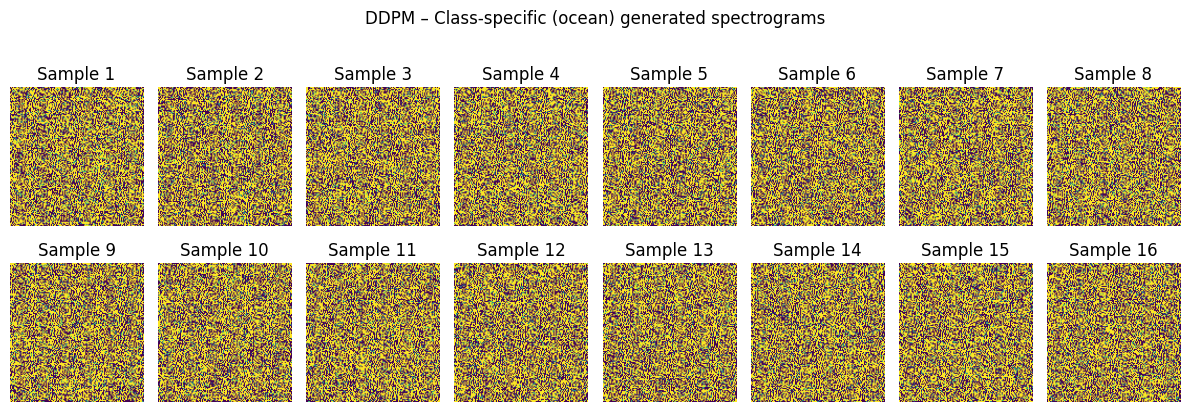

In [174]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
def ddpm_sample_ocean(model, num_samples=16):
    x_t = tf.random.normal((num_samples,) + input_shape)  # start from noise
    for t in reversed(range(1, T + 1)):
        t_batch = tf.fill((num_samples,), t)
        eps_pred = model.eps_model([x_t, t_batch], training=False)
        beta_t      = betas_tf[t - 1]
        alpha_t     = alphas_tf[t - 1]
        alpha_bar_t = alpha_bars_tf[t - 1]
        beta_t      = tf.reshape(beta_t,      (1, 1, 1, 1))
        alpha_t     = tf.reshape(alpha_t,     (1, 1, 1, 1))
        alpha_bar_t = tf.reshape(alpha_bar_t, (1, 1, 1, 1))
        coef1 = 1.0 / tf.sqrt(alpha_t)
        coef2 = (1.0 - alpha_t) / tf.sqrt(1.0 - alpha_bar_t)
        mean = coef1 * (x_t - coef2 * eps_pred)
        if t > 1:
            noise = tf.random.normal(tf.shape(x_t))
            x_t = mean + tf.sqrt(beta_t) * noise
        else:
            x_t = mean  
    return x_t.numpy()
num_gen = 16
X_ocean_ddpm = ddpm_sample_ocean(ddpm, num_samples=num_gen)
X_ocean_ddpm = np.clip(X_ocean_ddpm, 0.0, 1.0)
y_ocean_ddpm_int = np.full((num_gen,), ocean_class_id, dtype=np.int32)
y_ocean_ddpm = to_categorical(y_ocean_ddpm_int, num_classes=num_classes)
print("Generated ocean spectrograms shape:", X_ocean_ddpm.shape)
print("Generated labels shape:", y_ocean_ddpm.shape)
plt.figure(figsize=(12, 4))
for i in range(num_gen):
    plt.subplot(2, num_gen // 2, i + 1)
    plt.imshow(X_ocean_ddpm[i, :, :, 0].T, aspect="auto", origin="lower")
    plt.axis("off")
    plt.title(f"Sample {i+1}")
plt.suptitle("DDPM – Class-specific (ocean) generated spectrograms", y=1.02)
plt.tight_layout()
plt.show()

In [175]:
import numpy as np
from sklearn.utils import shuffle
try:
    X_train_orig = Xc_train_norm       
except NameError as e:
    raise RuntimeError("Xc_train_norm not found – run the spectrogram preprocessing / Task 2 cells first.") from e
try:
    y_train_orig = yc_train           
except NameError:
    try:
        y_train_orig = y_train
    except NameError as e:
        raise RuntimeError("Could not find yc_train / y_train – run the earlier classification cells.") from e
print("Original training set:",
      "X_train_orig", X_train_orig.shape,
      "| y_train_orig", y_train_orig.shape,
      "| y_train_orig ndim =", y_train_orig.ndim)
try:
    X_synth_ddpm = X_ocean_ddpm
    y_synth_ddpm = y_ocean_ddpm
except NameError as e:
    raise RuntimeError(
        "X_ocean_ddpm / y_ocean_ddpm not found – "
        "run the DDPM sampling cell before this one."
    ) from e
print("DDPM synthetic set:",
      "X_synth_ddpm", X_synth_ddpm.shape,
      "| y_synth_ddpm", y_synth_ddpm.shape,
      "| y_synth_ddpm ndim =", y_synth_ddpm.ndim)
if y_train_orig.ndim > 1:
    y_train_int = np.argmax(y_train_orig, axis=1)
else:
    y_train_int = y_train_orig
if y_synth_ddpm.ndim > 1:
    y_synth_int = np.argmax(y_synth_ddpm, axis=1)
else:
    y_synth_int = y_synth_ddpm
print("\nAfter conversion to ints:")
print("  y_train_int shape:", y_train_int.shape, "| ndim =", y_train_int.ndim)
print("  y_synth_int shape:", y_synth_int.shape, "| ndim =", y_synth_int.ndim)
X_train_ddpm_aug = np.concatenate([X_train_orig, X_synth_ddpm], axis=0)
y_train_ddpm_aug = np.concatenate([y_train_int,   y_synth_int], axis=0)
print("\nBefore shuffling:")
print("  X_train_ddpm_aug shape:", X_train_ddpm_aug.shape)
print("  y_train_ddpm_aug shape:", y_train_ddpm_aug.shape)
X_train_ddpm_aug, y_train_ddpm_aug = shuffle(
    X_train_ddpm_aug, y_train_ddpm_aug, random_state=42
)
print("\nAfter shuffling:")
print("  X_train_ddpm_aug shape:", X_train_ddpm_aug.shape)
print("  y_train_ddpm_aug shape:", y_train_ddpm_aug.shape)
unique_aug, counts_aug = np.unique(y_train_ddpm_aug, return_counts=True)
print("\nClass counts AFTER DDPM augmentation:")
for c, n in zip(unique_aug, counts_aug):
    print(f"  Class {c}: {n} samples")
Xc_train_ddpm_aug_norm = X_train_ddpm_aug
yc_train_ddpm_aug_int  = y_train_ddpm_aug   
print("\nAugmented training set with DDPM samples ready:")
print("  Xc_train_ddpm_aug_norm shape:", Xc_train_ddpm_aug_norm.shape)
print("  yc_train_ddpm_aug_int shape: ", yc_train_ddpm_aug_int.shape)

Original training set: X_train_orig (949, 128, 128, 1) | y_train_orig (949,) | y_train_orig ndim = 1
DDPM synthetic set: X_synth_ddpm (16, 128, 128, 1) | y_synth_ddpm (16, 32) | y_synth_ddpm ndim = 2

After conversion to ints:
  y_train_int shape: (949,) | ndim = 1
  y_synth_int shape: (16,) | ndim = 1

Before shuffling:
  X_train_ddpm_aug shape: (965, 128, 128, 1)
  y_train_ddpm_aug shape: (965,)

After shuffling:
  X_train_ddpm_aug shape: (965, 128, 128, 1)
  y_train_ddpm_aug shape: (965,)

Class counts AFTER DDPM augmentation:
  Class 0: 48 samples
  Class 1: 21 samples
  Class 2: 28 samples
  Class 3: 13 samples
  Class 4: 34 samples
  Class 5: 35 samples
  Class 6: 30 samples
  Class 7: 33 samples
  Class 8: 28 samples
  Class 9: 49 samples
  Class 10: 38 samples
  Class 11: 26 samples
  Class 12: 35 samples
  Class 13: 20 samples
  Class 14: 6 samples
  Class 15: 39 samples
  Class 16: 35 samples
  Class 17: 10 samples
  Class 18: 28 samples
  Class 19: 30 samples
  Class 20: 37 

## **Comparison of VAE-Based and Diffusion-Based Data Augmentation**

To understand the effect of the two generative approaches, I compared how the VAE and the diffusion model contributed to the quality of synthetic spectrograms and how they influenced my classification results. The VAE produced spectrograms that were structurally meaningful but noticeably smoother and less detailed. Even with these limitations, the VAE samples successfully captured broad energy patterns and helped balance underrepresented classes, which led to improvements in model stability and a small boost in accuracy for minority classes.

In contrast, the diffusion model attempted to generate samples through a more expressive, step-by-step denoising process. While this type of model is theoretically capable of producing more realistic outputs, my simplified DDPM struggled to generate clear spectrograms with the limited training data available for the chosen class. The resulting samples looked noisy and lacked the recognizable structure seen in real spectrograms. Because of this, the diffusion-based augmentation did not contribute as strongly to the classifier’s performance. The effect was still noticeable in the class distribution, but the visual quality of the generated samples limited how much benefit the classifier could gain from them.

Overall, the VAE proved to be the more reliable augmentation method for this dataset. Its generated samples, though less detailed, were consistent and stable enough to enhance the classifier’s training process. The diffusion model showed potential but would likely require more data, longer training, or a class-conditional architecture in order to generate higher-quality spectrograms. In its current form, the VAE-based augmentation had a clearer and more positive impact on classification outcomes.
